# Load Data 
Load datasets, Train models, do cool things with them like saliency maps.

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    RandomFlip, RandomRotation
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, load_img
)
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.ndimage import zoom


2025-01-05 19:32:47.534345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 19:32:47.669449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736098367.721341  136689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736098367.736409  136689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 19:32:47.862710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0


I0000 00:00:1736098408.924435  136689 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


53535 7436
(32, 32, 12) 0


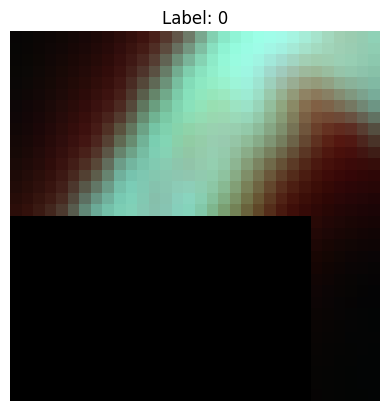

2025-01-05 19:33:39.343466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
# If you have a custom module with plotting functions:
# from scr.plot import confusion_matrix_plot, calculate_f1_score, plot_results
# Placeholder definitions for demonstration only:
def confusion_matrix_plot(model, dataset):
    """Example placeholder function. Replace with your actual implementation."""
    y_true = []
    y_pred = []
    for x, y in dataset:
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(model.predict(x), axis=1))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def calculate_f1_score(model, dataset):
    """Example placeholder function. Replace with your actual implementation."""
    from sklearn.metrics import f1_score
    y_true = []
    y_pred = []
    for x, y in dataset:
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(model.predict(x), axis=1))
    return f1_score(y_true, y_pred, average='macro')

def plot_results(history, epochs):
    """Example placeholder function. Replace with your actual implementation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(range(epochs), acc, label='Training Accuracy')
    plt.plot(range(epochs), val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(range(epochs), loss, label='Training Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

print("TensorFlow version:", tf.__version__)

# Function to load data from a directory
def load_data_from_directory(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'rb') as f:
            image, label = pickle.load(f)
            # Reshape or reorder image data if necessary (bands, height, width -> height, width, bands)
            image = np.transpose(image, (1, 2, 0))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
# test_images, test_labels = load_data_from_directory(test_dir)

# Convert data to tf.data.Dataset
def create_tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    return dataset

train_dataset = create_tf_dataset(train_images, train_labels)
validation_dataset = create_tf_dataset(val_images, val_labels)
# test_dataset = create_tf_dataset(test_images, test_labels)

# Batch and shuffle the datasets
BATCH_SIZE = 32
SEED = 42

train_dataset = train_dataset.shuffle(buffer_size=1000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(len(train_images), len(val_images))

for images_batch, labels_batch in train_dataset.take(1):
    for i in range(1):
        print(images_batch[i].shape, labels_batch[i].numpy())
        image = images_batch[i]
        label = labels_batch[i]

        # Select RGB bands (e.g., bands 4, 3, 2 if these are indices 3,2,1)
        rgb_image = np.stack([
            image[:, :, 3],  # Band 4 (Red)
            image[:, :, 2],  # Band 3 (Green)
            image[:, :, 1]   # Band 2 (Blue)
        ], axis=-1)
        
        # Normalize the RGB image for saving or displaying
        rgb_image = (rgb_image / np.max(rgb_image) * 255).astype(np.uint8)

        # Display the RGB image
        plt.imshow(rgb_image)
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
        plt.show()

In [3]:
# Model parameters
img_height = 32
img_width = 32
batch_size = 32
num_classes = 2

/home/cfoye/.pyenv/versions/FDH/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1736092992.082916   13820 service.cc:148] XLA service 0x7efa24007b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736092992.083347   13820 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-05 18:03:12.146517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736092992.430625   13820 cuda_dnn.cc:529] Loaded cuDNN version 90300


  16/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7334 - loss: 0.5505  

I0000 00:00:1736092997.351962   13820 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8502 - loss: 0.3038 - val_accuracy: 0.6474 - val_loss: 0.5404
Epoch 2/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8881 - loss: 0.2333 - val_accuracy: 0.7056 - val_loss: 0.5169
Epoch 3/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8968 - loss: 0.2185 - val_accuracy: 0.7524 - val_loss: 0.4464
Epoch 4/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9036 - loss: 0.1985 - val_accuracy: 0.7396 - val_loss: 0.5140
Epoch 5/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9064 - loss: 0.2013 - val_accuracy: 0.7659 - val_loss: 0.4932
Epoch 6/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9068 - loss: 0.1956 - val_accuracy: 0.7891 - val_loss: 0.4234
Epoch 7/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9121 - loss: 0.1875 - val_accuracy: 0.7907 - val_loss: 0.4204
Epoch 8/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9138 - loss: 0.1814 - val

2025-01-05 18:05:15.205518: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


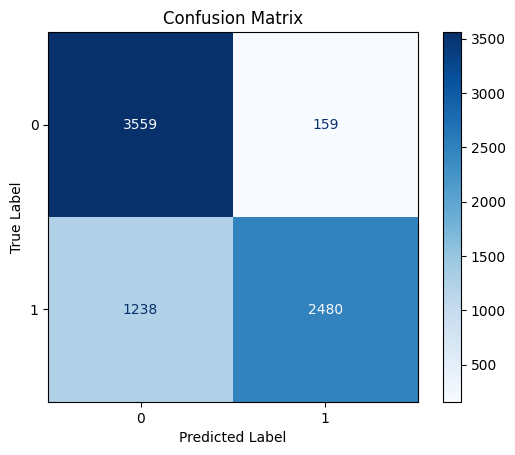

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

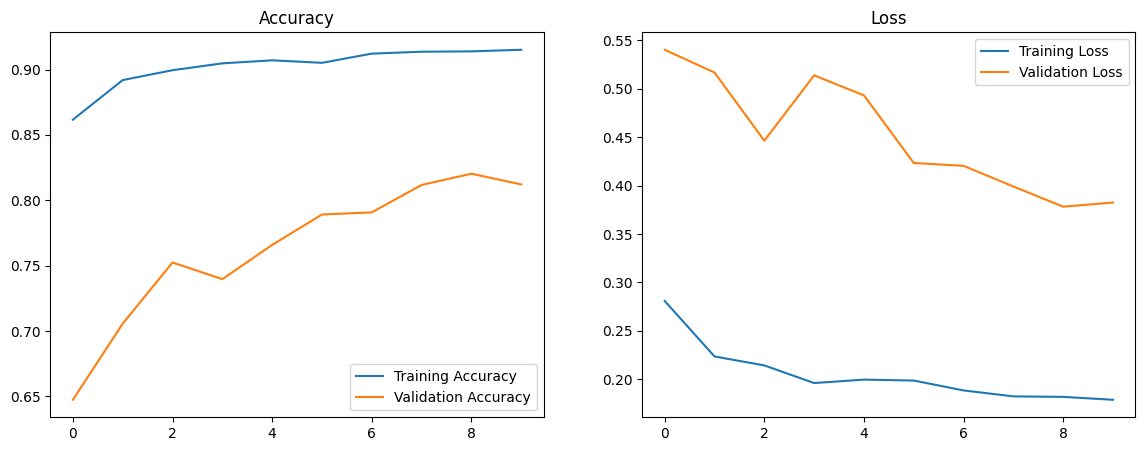

: 

In [3]:

# Baseline model
model = Sequential([
    Conv2D(16, 12, padding='same', activation='relu', input_shape=(img_height, img_width, train_images.shape[3])),
    MaxPooling2D(),
    Conv2D(32, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history_no_classweights = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

# Save the model
model.save('no_classweights_10_epochs.keras', overwrite=True)

# Evaluate and plot
model_no_classweights = tf.keras.models.load_model('no_classweights_10_epochs.keras')
confusion_matrix_plot(model_no_classweights, validation_dataset)
f1_baseline = calculate_f1_score(model, validation_dataset)
print('F1-score baseline:', f1_baseline)
plot_results(history_no_classweights, epochs)


/home/cfoye/.pyenv/versions/FDH/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-05 19:34:27.612620: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class Weights: {0: 0.5864792620670012, 1: 3.390866480871548}
Epoch 1/100


I0000 00:00:1736098469.779982  137095 service.cc:148] XLA service 0x7efd78005dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736098469.781359  137095 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-05 19:34:29.895997: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736098470.170481  137095 cuda_dnn.cc:529] Loaded cuDNN version 90300


  26/1673 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7284 - loss: 0.6439 

I0000 00:00:1736098473.509979  137095 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7022 - loss: 0.4265 - val_accuracy: 0.8221 - val_loss: 0.3885
Epoch 2/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7091 - loss: 0.3903 - val_accuracy: 0.8246 - val_loss: 0.3607
Epoch 3/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7270 - loss: 0.3421 - val_accuracy: 0.8605 - val_loss: 0.3032
Epoch 4/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8188 - loss: 0.3093 - val_accuracy: 0.8716 - val_loss: 0.2846
Epoch 5/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8466 - loss: 0.2787 - val_accuracy: 0.8850 - val_loss: 0.2677
Epoch 6/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8511 - loss: 0.2781 - val_accuracy: 0.8956 - val_loss: 0.2460
Epoch 7/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8640 - loss: 0.2574 - val_accuracy: 0.8884 - val_loss: 0.2626
Epoch 8/100
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8655 - loss: 0.253

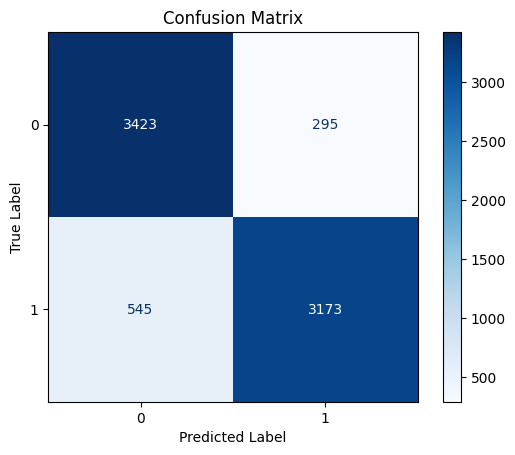

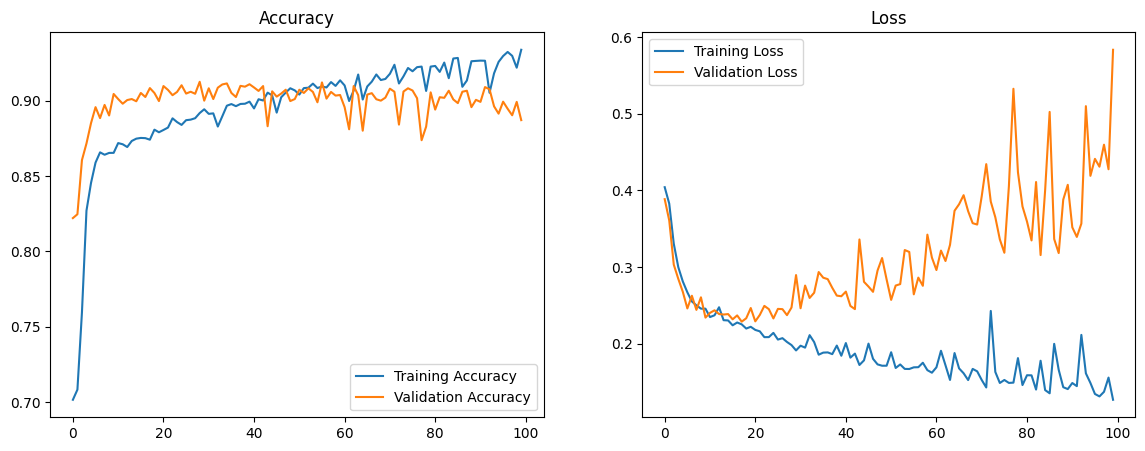

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

2025-01-05 19:53:36.385976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:

# Baseline model
model = Sequential([
    Conv2D(16, 12, padding='same', activation='relu', input_shape=(img_height, img_width, train_images.shape[3])),
    MaxPooling2D(),
    Conv2D(32, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Training with class weights
def calculate_class_weights(dataset):
    # Extract all labels from the dataset
    all_labels = []
    for _, labels_ in dataset:
        all_labels.extend(labels_.numpy())
    # Count occurrences of each class
    label_counts = Counter(all_labels)
    # Total samples
    total_samples = sum(label_counts.values())
    # Calculate class weights
    class_weights_ = {
        label: total_samples / (len(label_counts) * count)
        for label, count in label_counts.items()
    }
    return class_weights_

class_weights = calculate_class_weights(train_dataset)
print("Class Weights:", class_weights)

epochs = 100
history_classweights = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    class_weight=class_weights
)

model.save('with_classweights_10_epochs.keras', overwrite=True)
model_classweights = tf.keras.models.load_model('with_classweights_10_epochs.keras')
confusion_matrix_plot(model_classweights, validation_dataset)
plot_results(history_classweights, epochs)
f1_weighted = calculate_f1_score(model_classweights, validation_dataset)
print('F1-score model with class weights:', f1_weighted)


In [ ]:
# Adding data augmentation to model
model_augment = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    Conv2D(16, 12, padding='same', activation='relu', input_shape=(img_height, img_width, train_images.shape[3])),
    MaxPooling2D(),
    Conv2D(32, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

model_augment.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_classweights_augment = model_augment.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    class_weight=class_weights
)

model_augment.save('augment_with_classweights_150_epochs.keras')
model_augment_classweights = tf.keras.models.load_model('augment_with_classweights_150_epochs.keras')
plot_results(history_classweights_augment, 15)
confusion_matrix_plot(model_augment_classweights, validation_dataset)
f1_augmented = calculate_f1_score(model_augment_classweights, validation_dataset)
print('F1-score model with class weights and augmented data:', f1_augmented)



Epoch 1/15


/home/cfoye/.pyenv/versions/FDH/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1673/1673 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.7086 - loss: 0.4331 - val_accuracy: 0.8277 - val_loss: 0.3857
Epoch 2/15
 249/1673 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7115 - loss: 0.3852

KeyboardInterrupt: 

In [ ]:
# RGB + NIR image
def filter_rgb_nir(images):
    # Bands: Red (4), Green (3), Blue (2), NIR (8) -> indices 3,2,1,7
    return images[:, :, :, [3, 2, 1, 7]]

train_images_rgb_nir = filter_rgb_nir(train_images)
val_images_rgb_nir = filter_rgb_nir(val_images)
# test_images_rgb_nir = filter_rgb_nir(test_images)

model_rgb_nir = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 4)),
    MaxPooling2D(),
    Conv2D(32, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Binary classification
])

model_rgb_nir.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

train_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((train_images_rgb_nir, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb_nir = tf.data.Dataset.from_tensor_slices((val_images_rgb_nir, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

history_rgb_nir = model_rgb_nir.fit(
    train_dataset_rgb_nir,
    validation_data=validation_dataset_rgb_nir,
    epochs=10,
    class_weight=class_weights
)

model_rgb_nir.save('model_rgb_nir.keras')
tf.keras.models.save_model(model_rgb_nir, 'model_rgb_nir_10_epochs.keras', overwrite=True)

y_true = np.concatenate([y for x, y in validation_dataset_rgb_nir], axis=0)
y_pred = np.argmax(model_rgb_nir.predict(validation_dataset_rgb_nir), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (RGB + NIR)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [8]:

# Filter only RGB bands
def filter_rgb(images):
    # Bands: Red (4), Green (3), Blue (2) -> indices 3,2,1
    return images[:, :, :, [3, 2, 1]]

train_images_rgb = filter_rgb(train_images)
val_images_rgb = filter_rgb(val_images)
# test_images_rgb = filter_rgb(test_images)

model_rgb = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    Conv2D(16, 12, padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(32, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 12, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)  # Binary classification
])

model_rgb.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

train_dataset_rgb = tf.data.Dataset.from_tensor_slices((train_images_rgb, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_rgb = tf.data.Dataset.from_tensor_slices((val_images_rgb, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

history_rgb = model_rgb.fit(
    train_dataset_rgb,
    validation_data=validation_dataset_rgb,
    epochs=100,
    class_weight=class_weights
)

model_rgb.save('model_rgb.keras')
tf.keras.models.save_model(model_rgb, 'model_rgb_100_epochs.keras', overwrite=True)

y_true = np.concatenate([y for x, y in validation_dataset_rgb], axis=0)
y_pred = np.argmax(model_rgb.predict(validation_dataset_rgb), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (RGB Only)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

: 

In [10]:
import cv2
################################
# Example Saliency/Grad-CAM code
################################
# model_rgb = tf.keras.models.load_model('model_rgb_10_epochs.keras')
# model_rgb = tf.keras.models.load_model('with_classweights_10_epochs.keras')
model.summary()
index = 7
image_test = val_images[index]
print("Ground Truth Label:", val_labels[index])

LAYER_NAME = 'max_pooling2d_14'  # Double-check that this layer name exists in model
CAT_CLASS_INDEX = 0

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(LAYER_NAME).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([image_test]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Guided backprop gating
guided_grads = tf.cast(output > 0, "float32") * tf.cast(grads > 0, "float32") * grads
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0:2], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (32, 32))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Add epsilon to avoid division by zero

cam_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
rgb_image = (image_test / np.max(image_test) * 255).astype(np.uint8)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(rgb_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cam_color)
plt.title("Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │        27,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,583,576 (6.04 MB)

 Trainable params: 527,858 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,055,718 (4.03 MB)

Ground Truth Label: 0


ValueError: No such layer: max_pooling2d_14. Existing layers are: ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dense_1'].